In [28]:

import pandas as pd
import numpy as np
import pickle
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import scipy.fftpack as fftpack
from scipy.stats import binned_statistic

import argparse
import glob
from datetime import datetime

import F21DataLoader as dl


In [ ]:
import numpy as np

arr = np.array([1,2,3,4,5,6,7,8,9,10])
arr = arr[np.random.randint(len(arr), size=5)]
print(arr)

In [ ]:
def summarize_test(y_pred, y_test):
    print(f"y_pred: {y_pred}")
    print(f"y_test: {y_test}")
    # Calculate R2 scores
    r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(2)]
    print("R2 Score: " + str(r2))

    # Calculate rmse scores
    rmse = np.sqrt((y_test - y_pred) ** 2)
    rmse_comb = rmse[:,0]+rmse[:,1]/5 # Weighted as per the range of params
    print(f"rmse_comb : {rmse_comb.shape}\n{rmse_comb[:10]}")
    df_y = pd.DataFrame()
    df_y = df_y.assign(actual_xHI=y_test[:,0])
    df_y = df_y.assign(actual_logfX=y_test[:,1])
    df_y = df_y.assign(pred_xHI=y_pred[:,0])
    df_y = df_y.assign(pred_logfX=y_pred[:,1])
    df_y = df_y.assign(rmse_xHI=rmse[:,0])
    df_y = df_y.assign(rmse_logfx=rmse[:,1])
    df_y = df_y.assign(rmse=rmse_comb)
    print(f"Describing test data with rmse: {df_y.describe()}")

    df_y_agg = df_y.groupby(["actual_xHI", "actual_logfX"])['rmse'].mean()
    df_y_agg.rename('agg_rmse', inplace=True)
    df_y = df_y.merge(df_y_agg, on=['actual_xHI', 'actual_logfX'], validate='many_to_one')
    print(f"Describing data with rmse: \n{df_y.describe()}\n{df_y.head()}")

    rmse_summary = df_y.groupby(["actual_xHI", "actual_logfX"]).agg({'agg_rmse':'mean','rmse_xHI':'mean','rmse_logfx': 'mean'})
    print(f"rmse Summary: \n{rmse_summary}")

    cmap = plt.get_cmap('viridis')
    rmse = df_y['agg_rmse']
    rmse_min = rmse.min()
    rmse_max = rmse.max()
    norm = plt.Normalize(rmse.min(), rmse.max())
    colors = cmap(norm(rmse))    

    plt.rcParams['figure.figsize'] = [15, 9]
    plt.scatter(df_y['pred_xHI'], df_y['pred_logfX'], marker="o", s=49, label='Predicted', c=colors)
    plt.plot([df_y['pred_xHI'], df_y['actual_xHI']], [df_y['pred_logfX'], df_y['actual_logfX']], 'b--', alpha=0.5)
    plt.scatter(df_y['actual_xHI'], df_y['actual_logfX'], marker="X", s=100, label='Actual', c=colors)
    plt.xlim(0, 1)
    plt.ylim(-4, 1)
    plt.xlabel('xHI')
    plt.ylabel('logfX')
    plt.title('Predictions')
    plt.legend()
    plt.colorbar(label=f'RMS Error ({rmse_min:.2f} to {rmse_max:.2f})')
    plt.show()

summarize_test(np.array([
    [0.82, -0.25], 
    [0.82, 0.3], 
    [0.7, -1.3], 
    [0.5, -0.65]]), 
    np.array([
        [0.8, 0.0], 
        [0.8, 0.0], 
        [0.6, -1.0], 
        [0.6, -1.0]]))

In [ ]:
with open('alldatafiles.txt', 'r') as file:
    all_files = file.readlines()
    # Remove any whitespace/newlines
    all_files = [f.strip() for f in all_files]

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=16, random_state=42)
print('\n'.join(test_files))


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import load_model
from keras.losses import huber
import numpy as np

def create_cnn_model(input_shape):
    """Create a CNN model for regression"""
    model = models.Sequential([
        layers.Reshape((*input_shape, 1), input_shape=input_shape),
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.1),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(2)  # Output layer with 2 neurons for xHI and logfX
    ])

    # Compile the model  
    model.compile(loss=huber, optimizer='adam', metrics=['accuracy'])

    # Summary of the model
    model.summary()
    print("######## completed model setup #########")

    return model

print("Starting training")

X_train_subset = np.array([[1,2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9]])
y_train_subset = np.array([[2, 3], [3,4]])
print(f"Training dataset: X:{X_train_subset.shape} y:{y_train_subset.shape}")

# Create and compile the model
input_shape = (X_train_subset.shape[1],)
model = create_cnn_model(input_shape)
        
        # Early stopping callback
early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
)
    
print(f"{X_train_subset.shape}")
X_train_subset = X_train_subset.reshape(len(X_train_subset), X_train_subset.shape[1], 1)
print(f"Fitting data: {X_train_subset.shape}")
model.fit(
            X_train_subset, y_train_subset,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            #callbacks=[early_stopping],
            verbose=1
)

        # Test the model
print("Testing prediction")
#y_pred = model.predict(X_test)

In [ ]:
import numpy as np

def scaleXy(X, y):
    y[:,1] = 1 - (0.8 + y[:,1]/5.0)
    product = (y[:,0] * y[:,1]).reshape(len(y), 1)
    y = np.hstack((y, product))
            
    return X, y
            
def unscaleXy(X, y):
    y[:,1] = 5.0*(1 - y[:,1] - 0.8)
    y = y[:,:2]
    return X, y

def unscale_y(y):
    y[:,1] = 5.0*(1 - y[:,1] - 0.8)
    y = y[:,:2]

    return y

X = np.array([[]])
y = np.array([[0.0, 1.0],[1.0, -4.0], [0.25, -3.0], [0.25, -2.0], [0.25, -1.0], [0.1, -3.0], [0.4, -3.0]])
print(y)
X1, y1 = scaleXy(X,y)
print(y1)
y2 = unscale_y(y1)
print(y2)
y = np.array([[0.0, 1.0],[1.0, -4.0], [0.25, -3.0], [0.25, -2.0], [0.25, -1.0], [0.1, -3.0], [0.4, -3.0]])
X1, y1 = scaleXy(X,y)
print(y1)
_, y2 = unscaleXy(X1,y1)
print(y2)


In [ ]:
from sklearn.metrics import r2_score
import numpy as np

arr = np.array([[0.92505974, 0.6414318 ],
 [0.92505974, 0.87347054],
 [0.92505974, 0.7406077 ],
 [0.92505974, 0.930097  ],
 [0.92505974, 0.92294586],
 [0.92505974, 1.4816631 ],
 [0.92505974, 1.0506103 ],
 [0.92505974, 0.7624383 ],
 [0.92505974, 0.84898746],
 [0.92505974, 1.1804676 ],
 [3.3222392,  3.1889925 ],
 [3.3222392,  3.220426  ],
 [3.3222392,  3.3798876 ],
 [3.3222392,  3.0613034 ],
 [3.3222392,  3.4900947 ],
 [3.3222392,  3.377222  ],
 [3.3222392,  3.0877805 ],
 [3.3222392,  3.3594325 ],
 [3.3222392,  3.138997  ],
 [3.3222392,  3.232219  ]])
t = arr[:,0]
p = arr[:,1]
print(r2_score(t, p))


In [ ]:
y = np.array([[0.25, -1],[0.2, -2],[0.3, -2],[0.2, -3]])
print(y)
xHI = y[:, 0].reshape(len(y), 1)
scaledfx = 1 - (0.8 + y[:,1]/5.0).reshape(len(y), 1)
y=np.hstack((xHI, scaledfx))
print(y**2)
product = (((y[:,0]**2) + (y[:,1]**2))).reshape(len(y), 1)
y = np.hstack((xHI, scaledfx, product))
print(y)
y= y[:,2]
xHI = np.sqrt(0.5*y**2).reshape((len(y), 1))
fx = 5.0*(1 - xHI - 0.8)
print(np.hstack((xHI, fx)))

In [ ]:
import torch

tensor_2d = torch.tensor(np.stack([[1.1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],[1, 2, 3, 4, 5.5, 6, 7, 8, 9, 10, 11, 12]], axis=0))
print(tensor_2d)
# Reshape to a 2x3 tensor
tensor_3d = tensor_2d.view(4,6).T.view(2,3,4)
print(tensor_3d)
means = torch.mean(tensor_3d, 1).view()
print(means)

In [ ]:
import torch

tensor_1d = torch.tensor([1, 2, 3, 4, 5, 6])

# Reshape to a 2x3 tensor
tensor_2d = tensor_1d.reshape(2, 3)

print(tensor_2d)

In [ ]:
import torch
import timeit
from scipy import stats

X = np.random.randn(1*1*66).reshape(1*1, 66)
start_time = timeit.default_timer()
torchcalc = []
statcalc = []
for x in X:
    tensor_1d = torch.tensor(x)
    #print(tensor_1d)

    tensor_2d = tensor_1d.view(-1,33)
    print(tensor_2d.shape)
    pieces = np.array_split(x, len(x)//33)
    print(f"{len(pieces)}")
    means = torch.mean(tensor_2d, dim=1)
    print(f"means: {means}")
    smeans = [np.mean(p) for p in pieces]
    print(f"#means: {smeans}")
    std = torch.std(tensor_2d, dim=1, unbiased=False)
    print(f"std:{std}")
    sstd = [np.std(p) for p in pieces]
    print(f"#std:{sstd}")

    centered_x = tensor_2d - means.unsqueeze(1)
    skewness = torch.mean((centered_x / (std.unsqueeze(1) + 1e-8)) ** 3, dim=1)
    print(f"skewness: {skewness}")
    sskewness = [stats.skew(p) for p in pieces]
    print(f"#skewness: {sskewness}")

    mean_skew = torch.mean(skewness)
    print(f"mean skewness: {mean_skew}")
    print(f"#mean skewness: {np.mean(sskewness)}")

    std_skew = torch.std(skewness, unbiased=False)
    print(f"std skewness: {std_skew}")
    print(f"#std skewness: {np.std(sskewness)}")
    
    centered_skew = skewness - mean_skew
    skew2 = torch.mean((centered_skew / (std_skew.unsqueeze(0) + 1e-8)) ** 3)
    print(f"skew2: {skew2}")
    print(f"sskew2: {stats.skew(sskewness)}")
    
    torchcalc.append([mean_skew.item(), std_skew.item(), skew2.item()])
    

In [ ]:
arr = [1,2]
arr1 = [2, 3, 4]
arr.append(arr1)
print (arr)

In [ ]:
#X = np.random.randn(1*1*99).reshape(1*1, 99)
X= [[1.1, 2, 3, 1.4, 5, 6,7, 1.8, 9, 10, 1.1, 12]]
start_time = timeit.default_timer()
torchcalc = []
statcalc = []
for x in X:
    # Convert to PyTorch tensor and reshape into pieces of length 3
    tensor_1d = torch.tensor(x)
    tensor_2d = tensor_1d.view(-1, 3)  # Reshape into n x 3 matrix
    print(f"Data in groups of 3:\n{tensor_2d}")

    # Calculate mean and std for each group
    means = torch.mean(tensor_2d, dim=1)
    std = torch.std(tensor_2d, dim=1, unbiased=False)

    print(f"\nMeans for each group: {means}")
    pieces = np.array_split(x, len(x)//4)
    # Calculate statistics for each piece
    print(f"#means:\n{[np.mean(p) for p in pieces]}")
    print(f"std:\n{std}")
    print(f"#std:\n{[np.std(p) for p in pieces]}")

    centered_x = tensor_2d - means
    print(f"centered:\n{centered_x}")
    skewness = torch.mean((centered_x / std) ** 3, dim=1)
    print(f"skewness: {skewness}")
    skewness = [stats.skew(p) for p in pieces]
    print(f"#skewness: {skewness}")
    mean_skew = torch.mean(skewness, 1)
    std_skew = torch.std(skewness)
    print(f"mean and std_skew {mean_skew}, {std_skew}")
    centered_skew = skewness - mean_skew
    skew2 = torch.mean((centered_skew / std_skew) ** 3)
    torchcalc.append([mean_skew.item(), std_skew.item(), skew2.item()])
    print("#####")
    mean_skew = np.mean(skewness)
    std_skew = np.std(skewness)
    print(f"mean and std_skew {mean_skew}, {std_skew}")
    min_skew = np.min(skewness)
    skew2 = stats.skew(skewness)
    #print(means)
    statcalc.append([mean_skew, std_skew, skew2])

print(torchcalc)
print(statcalc)

In [ ]:
import sys
import os

print(os.sep)
print(sys.argv[0].split(sep=os.sep)[-1])

In [ ]:
import numpy as np

y_pred = np.array([[2,5],[3,6]])
print(np.mean(y_pred, axis=0))
print(np.mean(y_pred, axis=1))
print(np.mean(y_pred))

In [ ]:
import importlib
import f21_predict_base as base
import plot_results as pltr

importlib.reload(base)

y_pred, y_test = base.load_test_results("output/f21_ps_xgb_train_test_uGMRT_t500h_b1_20241217230419_score0.81_nolog_nosub/test_results.csv")

#y_pred, y_test = base.load_test_results("output/f21_ps_xgb_train_test_uGMRT_t500h_b1_20241211181648/test_results.csv")
#y_pred, y_test = base.load_test_results("output/f21_ps_xgb_train_test_uGMRT_t500h_b1_20241217143106_noisesub_b10/test_results.csv")

pltr.summarize_test_1000(y_pred, y_test, showplots=True, saveplots=False)


<>:80: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_53824/2012366722.py:80: SyntaxWarning: invalid escape sequence '\l'
  """
/var/folders/wz/tf9bd1d17kxcg2r9f2875tv00000gn/T/ipykernel_53824/2012366722.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(corresponding_preds[:, 0], corresponding_preds[:, 1],


summarize_test_1000: Summarizing results pred shape:(120000, 2) actual shape: (120000, 2)
sample y_test: [[ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]
 [ 0.11 -1.  ]]
sample y_pred: [[ 0.14798528 -0.24742545]
 [ 0.283889    0.10171294]
 [ 0.53019899 -0.10868593]
 [ 0.46887466 -0.03205203]
 [ 0.42281112 -0.55029345]
 [ 0.64240748  0.26181436]
 [ 0.64264566 -0.31773582]
 [ 0.39979067 -0.03081807]
 [ 0.32718465  0.33544588]
 [ 0.25564405 -0.0925476 ]]
Number of unique test points: 12
Unique test points: [[ 0.11 -3.  ]
 [ 0.11 -2.  ]
 [ 0.11 -1.  ]
 [ 0.25 -3.  ]
 [ 0.25 -2.  ]
 [ 0.25 -1.  ]
 [ 0.52 -3.  ]
 [ 0.52 -2.  ]
 [ 0.52 -1.  ]
 [ 0.8  -3.  ]
 [ 0.8  -2.  ]
 [ 0.8  -1.  ]]


<Figure size 1200x600 with 0 Axes>

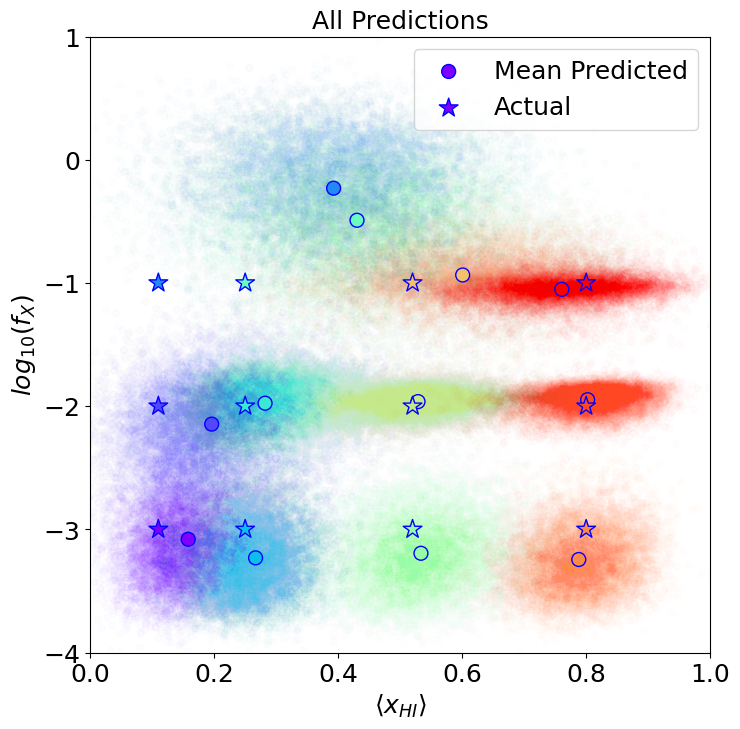

<Figure size 800x800 with 0 Axes>

In [4]:
# Create a 2D scatter plot
import matplotlib.pyplot as plt
import numpy as np
import importlib
import f21_predict_base as base
import plot_results as pltr

importlib.reload(base)
base.initplt()

import Scaling

class Args:
    def __init__(self, runmode='', telescope='uGMRT', t_int=500):
        self.runmode = runmode
        self.telescope = telescope
        self.t_int = t_int
        self.scale_y = True

args = Args() 

#y_test,y_pred = base.load_test_results("output/train_test_xgb__uGMRT_t500_20250115123329_Optimal/test_results.csv")
y_pred, y_test = base.load_test_results("output/f21_inference_unet_train_test_uGMRT_t500.0_20250219212607/test_results.csv")
#y_pred = Scaling.Scaler(args).unscale_y(y_pred)
#y_test = Scaling.Scaler(args).unscale_y(y_test)
y_test = y_test.round(decimals=2)
print(f"summarize_test_1000: Summarizing results pred shape:{y_pred.shape} actual shape: {y_test.shape}")
print(f"sample y_test: {y_test[:10]}")
print(f"sample y_pred: {y_pred[:10]}")
# Create unique identifier for each test point
unique_test_points = np.unique(y_test, axis=0)
print(f"Number of unique test points: {len(unique_test_points)}")
print(f"Unique test points: {unique_test_points}")


# Calculate mean predictions for each unique test point
mean_predictions = []
std_predictions = []

for test_point in unique_test_points:
    # Find all predictions corresponding to this test point
    mask = np.all(y_test == test_point, axis=1)
    corresponding_preds = y_pred[mask]
    #print(f"Test point: {test_point}, Number of preds: {len(corresponding_preds)}")
    # Calculate mean and std of predictions
    mean_pred = np.mean(corresponding_preds, axis=0)
    std_pred = np.std(corresponding_preds, axis=0)
    #print(f"Test point: {test_point}, Number of preds: {len(corresponding_preds)}, Mean: {mean_pred}, Std: {std_pred}")
    
    mean_predictions.append(mean_pred)
    std_predictions.append(std_pred)

mean_predictions = np.array(mean_predictions)
std_predictions = np.array(std_predictions)

plt.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots()

num_points = len(unique_test_points)
colors = plt.cm.rainbow(np.linspace(0, 1, num_points))
"""
# Plot std dev contours
for i in range(len(unique_test_points)):
    # Create ellipse points
    theta = np.linspace(0, 2*np.pi, 100)
    x = mean_predictions[i, 0] + std_predictions[i, 0] * np.cos(theta)
    y = mean_predictions[i, 1] + std_predictions[i, 1] * np.sin(theta)
    plt.plot(x, y, 'k--', alpha=0.4)
    theta = np.linspace(0, 2*np.pi, 100)
    x = mean_predictions[i, 0] + 2 * std_predictions[i, 0] * np.cos(theta)
    y = mean_predictions[i, 1] + 2 * std_predictions[i, 1] * np.sin(theta)
    plt.plot(x, y, 'k--', alpha=0.2)
"""
# Plot all 10000 predctions
for i, test_point in enumerate(unique_test_points):
    # Find all predictions corresponding to this test point
    mask = np.all(y_test == test_point, axis=1)
    corresponding_preds = y_pred[mask]
    plt.scatter(corresponding_preds[:, 0], corresponding_preds[:, 1], 
           marker="o", s=25, alpha=0.01, c=colors[i])
"""
# Make a line from the actual point to the mean of the predictions
plt.plot([mean_predictions[:, 0], unique_test_points[:, 0]], 
         [mean_predictions[:, 1], unique_test_points[:, 1]], 
         'k--', alpha=0.4)

    # For each unique test point, create contours of predictions
    for i, test_point in enumerate(unique_test_points):
        # Find all predictions corresponding to this test point
        mask = np.all(y_test == test_point, axis=1)
        corresponding_preds = y_pred[mask]
        x, y = corresponding_preds[:, 0], corresponding_preds[:, 1]
        # Step 2: Normalize the histogram to get the probability density
        # Get the bin counts and edges
        counts, xedges, yedges = np.histogram2d(x, y, bins=18)
        # Normalize the counts to create a probability density function
        pdf = counts / np.sum(counts)
        # Find the levels that correspond to 68% and 95% confidence intervals
        level_68 = np.percentile(pdf, 68)
        level_95 = np.percentile(pdf, 95)
        # Step 4: Create the contour plot
        plt.contourf(xedges[:-1], yedges[:-1], pdf.T, levels=[level_68,level_95,np.max(pdf)],colors=[colors[i],colors[i]],alpha=[0.3,0.6])
        plt.contour(xedges[:-1], yedges[:-1], pdf.T, levels=[level_68,level_95,np.max(pdf)],colors=[colors[i],colors[i]],linewidths=0.5)
        plt.xlim(0,1)
        plt.ylim(-4,0)
        plt.tick_params(axis='both', direction='in', length=10)  # Inward ticks with length 10
        plt.xlabel(r"$\langle x_{HI}\rangle$")
        plt.ylabel(r"$log_{10}(f_X)$")
        
        if i == 0: print(f"## {test_point}, {corresponding_preds.shape} {corresponding_preds[0]}")
        mean_point = np.mean(corresponding_preds, axis=0)
        
        sorted_indices = np.argsort(np.apply_along_axis(distance, 1, corresponding_preds, mean_point))
        sorted_points = corresponding_preds[sorted_indices]
                    
        # Calculate cumulative distribution
        # Find thresholds for 68% and 95% confidence levels
        threshold_68 = int(0.68 * len(sorted_points))
        threshold_95 = int(0.95 * len(sorted_points))
        if i == 0: print(f"{threshold_68}, {threshold_95}")
        # Create grid for contour plotting
        #print(f"{threshold_68},{threshold_95}")
"""
    
# Plot mean predictions
plt.scatter(mean_predictions[:, 0], mean_predictions[:, 1], 
           marker="o", edgecolor='b', s=100, label='Mean Predicted', alpha=1, c=colors)
# Plot actual points
plt.scatter(unique_test_points[:, 0], unique_test_points[:, 1], 
           marker="*", edgecolor='b', s=200, label='Actual', c=colors)

plt.xlim(0, 1)
plt.ylim(-4, 1)

plt.xlabel(r'$\langle x_{HI}\rangle$', fontsize=18)
plt.ylabel(r'$log_{10}(f_X)$', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('All Predictions', fontsize=18)
plt.legend()

plt.show()
plt.clf()



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import f21_predict_base as base
import plot_results as pltr


def map_to_unique_integer(actual_xHI, actual_logfX):


    # Normalize actual_xHI and actual_logfX to the range [0, 1]
    norm_xHI = (actual_xHI - np.min(actual_xHI)) / (np.max(actual_xHI) - np.min(actual_xHI))
    norm_logfX = (actual_logfX - np.min(actual_logfX)) / (np.max(actual_logfX) - np.min(actual_logfX))

    # Combine the normalized values to create a unique integer mapping
    unique_mapping = (norm_xHI * 11).astype(int) + (norm_logfX * 11).astype(int) * 11
    print(unique_mapping)
    # Ensure the mapping is between 0 and 11
    unique_mapping = unique_mapping % 12 # np.clip(unique_mapping, 0, 11)

    return unique_mapping


# ... existing code ...

In [ ]:

# Load the CSV file as a NumPy array, treating the first row as headers
data = np.genfromtxt('output/f21_inference_unet_train_test_uGMRT_t500.0_20250215045101/test_predictions.csv', delimiter=',', skip_header=1)

# Extract the columns
actual_xHI = data[:, 0]  # First column
actual_logfX = data[:, 1]  # Second column
predicted_xHI = data[:, 2]  # Third column
predicted_logfX = data[:, 3]  # Fourth column

# Create a scatter plot
base.initplt()
colors = plt.cm.rainbow(np.linspace(0, 1, 12))
col_ind = map_to_unique_integer(actual_xHI, actual_logfX)
print(col_ind)

# Scatter plot for actual values
plt.scatter(actual_xHI, actual_logfX, marker='*', label='Actual', c=colors[col_ind], alpha=0.8, s=100)

# Scatter plot for predicted values
plt.scatter(predicted_xHI, predicted_logfX, marker='o', label='Predicted', c=colors[col_ind], alpha=0.8, s=100)

# Adding labels and title
plt.xlabel(r'$\langle xHI\rangle$')
plt.ylabel(r'log$_{10}(f_X)$')
plt.title('Scatter Plot of Cosmological Parameter Inference')
plt.legend()
#plt.colorbar(label='Color based on Actual Parameters')
plt.show()

In [ ]:
            X = corresponding_preds[:,0]
            Y = corresponding_preds[:,1]
            mean_x, mean_y = np.mean(X), np.mean(Y)

            # Compute distances from the mean
            distances = np.sqrt((X - mean_x)**2 + ((Y - mean_y)**2))

            # Sort distances and calculate thresholds for 68% and 95% levels
            sorted_distances = np.sort(distances)

            threshold_68 = sorted_distances[int(0.68 * len(sorted_distances))]
            threshold_95 = sorted_distances[int(0.95 * len(sorted_distances))]

            # Create a grid of points for plotting
            grid_x, grid_y = np.meshgrid(
                np.linspace(X.min(), X.max(), 500),
                np.linspace(Y.min(), Y.max(), 500)
            )
            grid_distances = np.sqrt((X - mean_x)**2 + ((Y - mean_y)**2))
            plt.contourf(grid_x, grid_y, grid_distances, levels=[0, threshold_68, threshold_95])            
            
        

In [ ]:
def plot(y_pred, y_test)        
    plt.rcParams['figure.figsize'] = [15, 9]
    fig, ax = plt.subplots()
        
    num_points = len(unique_test_points)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_points))
        """
        # Plot std dev contours
        for i in range(len(unique_test_points)):
            # Create ellipse points
            theta = np.linspace(0, 2*np.pi, 100)
            x = mean_predictions[i, 0] + std_predictions[i, 0] * np.cos(theta)
            y = mean_predictions[i, 1] + std_predictions[i, 1] * np.sin(theta)
            plt.plot(x, y, 'k--', alpha=0.4)

            theta = np.linspace(0, 2*np.pi, 100)
            x = mean_predictions[i, 0] + 2 * std_predictions[i, 0] * np.cos(theta)
            y = mean_predictions[i, 1] + 2 * std_predictions[i, 1] * np.sin(theta)
            plt.plot(x, y, 'k--', alpha=0.2)
        
        # Plot all 10000 predctions
        for i, test_point in enumerate(unique_test_points):
            # Find all predictions corresponding to this test point
            mask = np.all(y_test == test_point, axis=1)
            corresponding_preds = y_pred[mask]
            plt.scatter(corresponding_preds[:, 0], corresponding_preds[:, 1], 
                   marker="o", s=25, alpha=0.01, c=colors[i])
        # Make a line from the actual point to the mean of the predictions
        plt.plot([mean_predictions[:, 0], unique_test_points[:, 0]], 
                 [mean_predictions[:, 1], unique_test_points[:, 1]], 
                 'k--', alpha=0.4)

        """
        # For each unique test point, create contours of predictions
        for i, test_point in enumerate(unique_test_points):
            # Find all predictions corresponding to this test point
            mask = np.all(y_test == test_point, axis=1)
            corresponding_preds = y_pred[mask]
            
            # Create a 2D histogram of predictions
            H, xedges, yedges = np.histogram2d(
                corresponding_preds[:, 0],  # xHI predictions
                corresponding_preds[:, 1],  # logfX predictions
                bins=20
            )
            
            # Calculate cumulative distribution
            H_sorted = np.sort(H.flatten())
            H_cumsum = np.cumsum(H_sorted) / np.sum(H)
            
            # Find thresholds for 68% and 95% confidence levels
            threshold_68 = H_sorted[np.searchsorted(H_cumsum, 0.68)]
            threshold_95 = H_sorted[np.searchsorted(H_cumsum, 0.95)]
            
            # Create grid for contour plotting
            X, Y = np.meshgrid(
                (xedges[1:] + xedges[:-1])/2,
                (yedges[1:] + yedges[:-1])/2
            )
            
            #print(f"{threshold_68},{threshold_95}")
            # Plot contours
            plt.contourf(X, Y, H.T, 
                        levels=[threshold_68, threshold_95],
                        colors=[colors[i]], 
                        alpha=0.5,
                        linestyles=['solid', 'dashed'])
            
        
        # Plot mean predictions
        plt.scatter(mean_predictions[:, 0], mean_predictions[:, 1], 
                   marker="x", s=200, label='Mean Predicted', alpha=1, c=colors)

        # Plot actual points
        plt.scatter(unique_test_points[:, 0], unique_test_points[:, 1], 
                   marker="*", s=200, label='Actual', c=colors)
        
        plt.xlim(0, 1)
        plt.ylim(-4, 1)
        
        plt.xlabel(r'$\langle x_{HI}\rangle$', fontsize=18)
        plt.ylabel(r'$log_{10}(f_X)$', fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.title('Mean Predictions with  ±1σ and ±2σ Contours', fontsize=18)
        plt.legend()
        
        if showplots: plt.show()

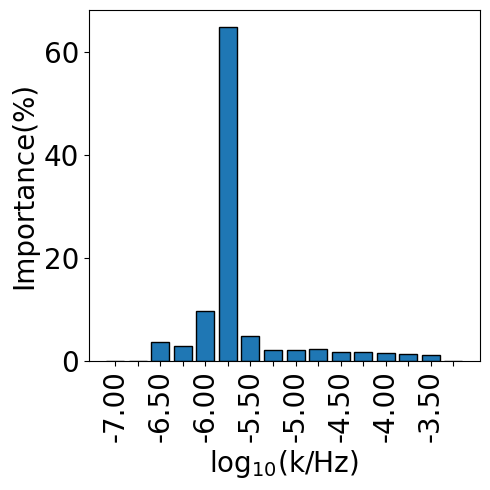

In [6]:
import csv
import matplotlib.pyplot as plt
import os
import f21_predict_base as base

# Read CSV file without pandas
filename = "saved_output/inference_gmrt50h/noisy_ps_f21_inference_ps_train_test_uGMRT_t50.0_20250418124600/feature_importance_edit.csv"
x_labels = []
y_values = []

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    headers = next(reader)  # Skip header row
    for row in reader:
        x_labels.append(row[0])
        raw_value = row[3].strip()
        trimmed_value = raw_value[:-1]  # Remove last character
        y_values.append(float(trimmed_value))

# Plot settings for MNRAS-style figure
base.initplt()
#plt.figure(figsize=(6, 3))  # Suitable for single-column width in MNRAS
plt.bar(x_labels, y_values, edgecolor='black')

plt.xlabel(r"log$_{10}$(k/Hz)")
plt.ylabel("Importance(%)")
xtick_positions = list(range(len(x_labels)))
xtick_labels = [label if i % 2 == 0 else "" for i, label in enumerate(x_labels)]
plt.xticks(xtick_positions, xtick_labels, rotation=90)
plt.yticks()
plt.tight_layout()

# Save as PDF
output_dir = "tmp_out"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "feature_importance_plot.pdf")
plt.savefig(output_path, format="pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()
